
<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398 Aprendizaje Automático </h1>

<H3 align='center'> Tarea/Taller 2 </H3>
<hr style="height:2px;border:none"/>



# Temas

* Regresión Lineal
* Regularización
* Selección de Características
* Reducción de Dimensionalidad


# Parte 2. **Desafío Kaggle** 

En esta competencia, se le pide crear un modelo que sugiera automáticamente los precios correctos de los productos. Se le proporcionarán descripciones de texto y detalles como la categoría del producto, el nombre de la marca y la condición del artículo.


https://www.kaggle.com/competitions/price-predictionml



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import string
import json
import warnings
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() # lematizador
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lucio\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df_train = pd.read_csv('price-predictionml/data/train.csv')
df_test = pd.read_csv('price-predictionml/data/test.csv')
categories = pd.read_json('price-predictionml/data/categories.json', typ='series')
categories = pd.DataFrame(categories).reset_index()
categories.columns = ['category_id', 'category_name']
df_train = df_train.set_index('train_id')
df_test = df_test.set_index('train_id')

In [3]:
categories.sort_values(by='category_id').head()

,category_id,category_name
133,0,Beauty/Bath & Body/Bath
581,1,Beauty/Bath & Body/Bathing Accessories
285,2,Beauty/Bath & Body/Cleansers
561,3,Beauty/Bath & Body/Other
359,4,Beauty/Bath & Body/Scrubs & Body Treatments


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107156 entries, 196020 to 343457
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1107156 non-null  object 
 1   item_condition_id  1107156 non-null  object 
 2   category_name      1107156 non-null  int64  
 3   brand_name         635451 non-null   object 
 4   price              1107156 non-null  float64
 5   shipping           1107156 non-null  int64  
 6   item_description   1107152 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.6+ MB


In [5]:
df_train.dtypes.value_counts()

object     4
int64      2
float64    1
dtype: int64

In [6]:
df_train['item_condition_id'].value_counts()

New (codes: BNWT, BNIP MIB, NWT, NIB, BNIB)    478366
Good                                           322963
Like New (codes: BNWOT, MWOB, NWOT, BNWOB)     280120
Fair                                            23911
Poor                                             1796
Name: item_condition_id, dtype: int64

In [7]:
# cambiaremos los valores categóricos de la condition por unos mas cortos para mejor visualización
df_train['item_condition_id'] = df_train['item_condition_id'].map({'New (codes: BNWT, BNIP MIB, NWT, NIB, BNIB)': 'New',
                                                                   'Like New (codes: BNWOT, MWOB, NWOT, BNWOB)': 'Like New',
                                                                   'Good': 'Good',
                                                                   'Fair': 'Fair',
                                                                   'Poor': 'Poor'})

# cambiaremos los valores categóricos de la condition por unos mas cortos para mejor visualización
df_test['item_condition_id'] = df_test['item_condition_id'].map({'New (codes: BNWT, BNIP MIB, NWT, NIB, BNIB)': 'New',
                                                                   'Like New (codes: BNWOT, MWOB, NWOT, BNWOB)': 'Like New',
                                                                   'Good': 'Good',
                                                                   'Fair': 'Fair',
                                                                   'Poor': 'Poor'})

In [8]:
df_train['item_condition_id'].value_counts()

New         478366
Good        322963
Like New    280120
Fair         23911
Poor          1796
Name: item_condition_id, dtype: int64

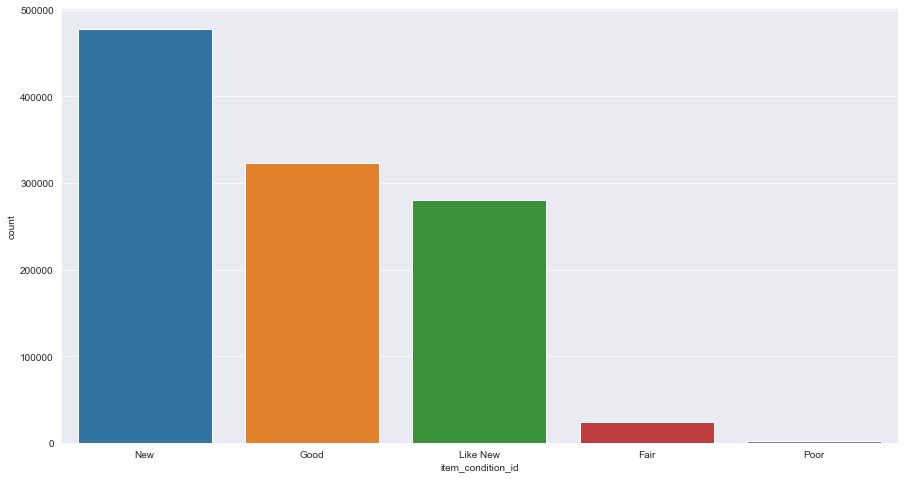

In [9]:
plt.figure(figsize=(15,8))
sns.countplot(x = 'item_condition_id',
              data = df_train,
              order = df_train['item_condition_id'].value_counts().index)
plt.show()

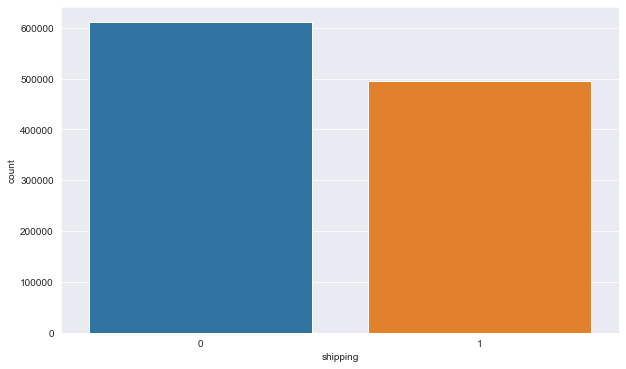

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x=df_train['shipping'])

In [11]:
categorical_columns = ["category_name", 
                       "brand_name",
                       "item_condition_id", 
                       "item_description"]

In [12]:
df_train['price'].sort_values(ascending=False)

train_id
760469     1932658.0
1262245    1929772.0
1393600    1927848.0
742113     1924000.0
415027     1924000.0
             ...    
491632           0.0
1409432          0.0
156674           0.0
408952           0.0
643475           0.0
Name: price, Length: 1107156, dtype: float64

In [13]:
# veamos cuantos valores nulos tienen las columnas
print(df_train.isnull().sum(axis = 0))

name                      0
item_condition_id         0
category_name             0
brand_name           471705
price                     0
shipping                  0
item_description          4
dtype: int64


In [14]:
df_train[df_train['brand_name'].isnull()]

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
441251,Purple Bikini Top,Like New,1253,NaN,11544.0,0,"Double strap bikini top, no brand. Size small,..."
1035108,Hair product,New,13,NaN,61568.0,0,Wen by Chaz Dean Comes with 3 Cleansing Condit...
118783,Baby girl lot,Good,626,NaN,9620.0,0,"All clothes with 6,6-9 months white bottoms 3-..."
90744,NEW SEXY BANDAGE BIKINI,New,1252,NaN,17316.0,1,◾️BRAND NEW--limited availability--2 available...
342067,Sale❣2 Matte For Jasmine Only!,New,28,NaN,9620.0,1,For Jasmine ONLY! Madly Matte Lipgloss by Klea...
...,...,...,...,...,...,...,...
1290399,BUNDLE FOR KAYLA,Good,1260,NaN,29822.0,0,No description yet
1207482,Bundle For KB Short,Like New,1193,NaN,29822.0,0,•MK Ivory 2 •Maurices Jegging size 17 •RXB XL ...
454688,Black twilly scarf one pair,New,1274,NaN,15392.0,0,New pair twilly scarves of your bag accessorie...


In [15]:
# porcentaje de valores nulos de los nombres de la marca del producto
null_brand_names = df_train['brand_name'].isnull().sum()/(df_train['brand_name'].notnull().sum() + df_train['brand_name'].isnull().sum())
print(f"Hay un {np.round(null_brand_names*100, 2)}% de valores nulos en brand_name")

Hay un 42.61% de valores nulos en brand_name


In [16]:
df_train['brand_name'].describe()

count     635451
unique      4429
top         Nike
freq       40468
Name: brand_name, dtype: object

In [17]:
# rellenaremos los valores nulos con marca desconocida
df_train['brand_name'].fillna('unknown', inplace=True)
df_test['brand_name'].fillna('unknown', inplace=True)

# dropeamos las filas restantes que tienen nan
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


In [18]:
# veamos cuantos valores nulos tienen las columnas
print(df_train.isnull().sum(axis = 0))

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64


In [19]:
gr = df_train.groupby(['brand_name']).size().reset_index(name='counts') 
gr = gr.sort_values(by='counts', ascending=False)
gr

,brand_name,counts
4428,unknown,471702
2824,Nike,40468
2977,PINK,40392
4157,Victoria's Secret,36180
2410,LuLaRoe,23124
...,...,...
1724,Happy Chic Baby by Jonathan Adler,1
3441,SAS Safety Corp.,1
1725,Happy Socks,1
3439,Ruth,1


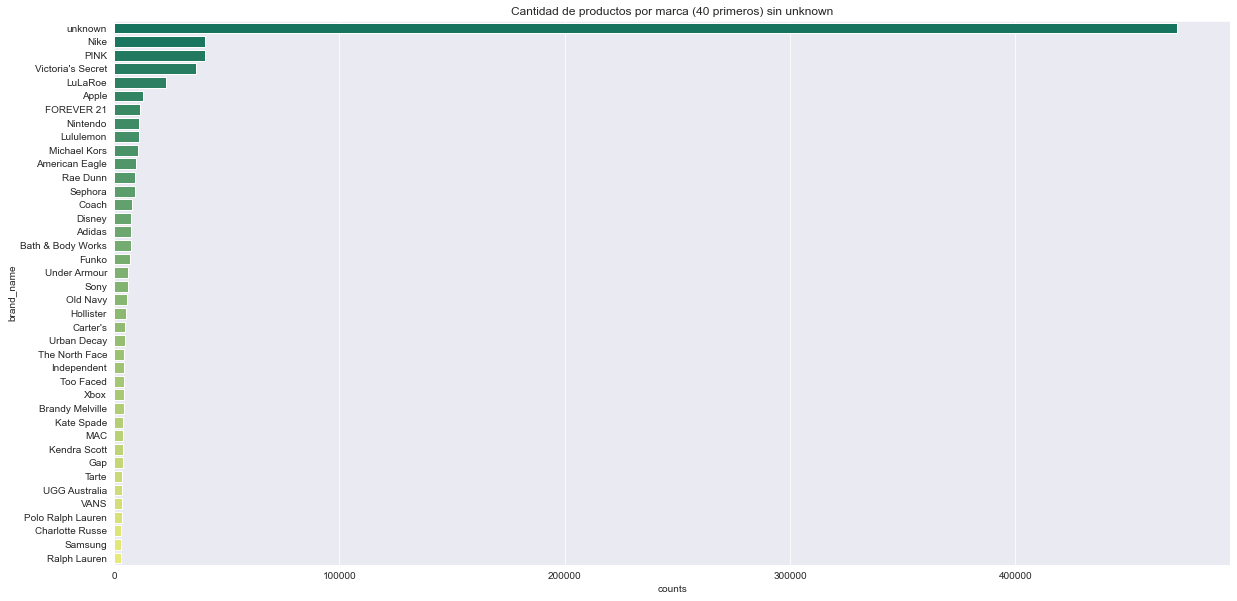

In [20]:
fig, ax = plt.subplots(figsize=(20,10),nrows=1)
sns.barplot(data=gr.head(40), y='brand_name', x='counts', palette="summer",ax=ax)
ax.set_title('Cantidad de productos por marca (40 primeros) sin unknown')
plt.show()

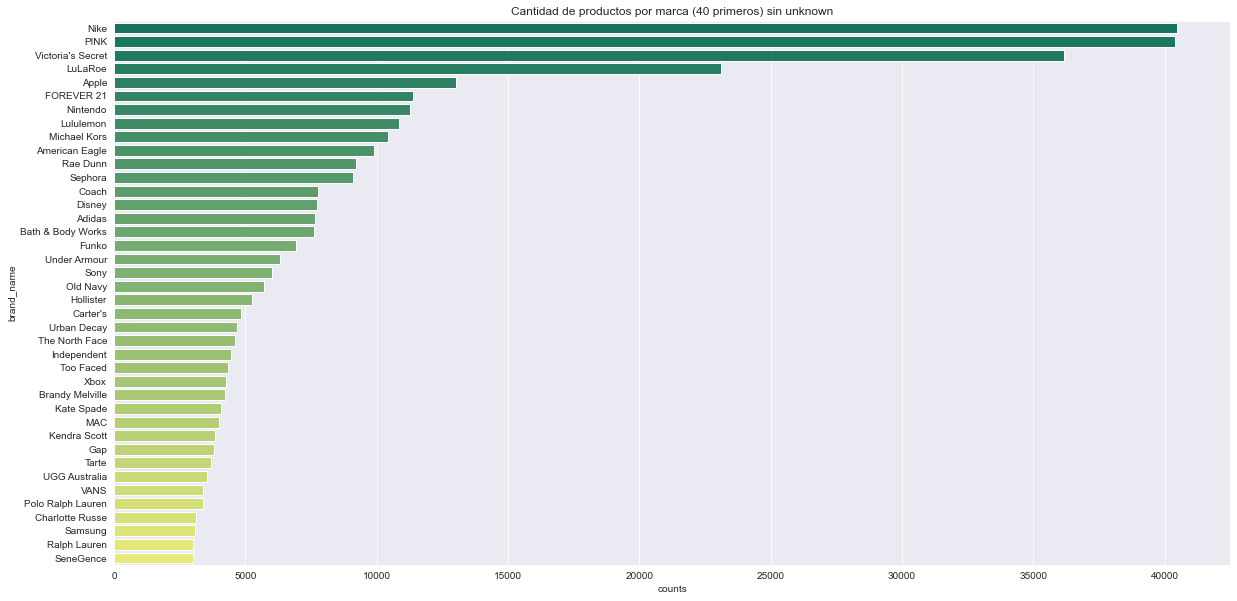

In [21]:
fig, ax = plt.subplots(figsize=(20,10),nrows=1)
sns.barplot(data=gr[1: ].head(40), y='brand_name', x='counts', palette="summer",ax=ax)
ax.set_title('Cantidad de productos por marca (40 primeros) sin unknown')
plt.show()

In [22]:
df_train['price']

train_id
196020     17316.0
441251     11544.0
1035108    61568.0
1168977    11544.0
118783      9620.0
            ...   
334426     32708.0
1050522    15392.0
758098      8658.0
1245337     4810.0
343457      2886.0
Name: price, Length: 1107152, dtype: float64

In [23]:
df_train['price'].describe(
)

count    1.107152e+06
mean     2.572718e+04
std      3.735269e+04
min      0.000000e+00
25%      9.620000e+03
50%      1.635400e+04
75%      2.789800e+04
max      1.932658e+06
Name: price, dtype: float64

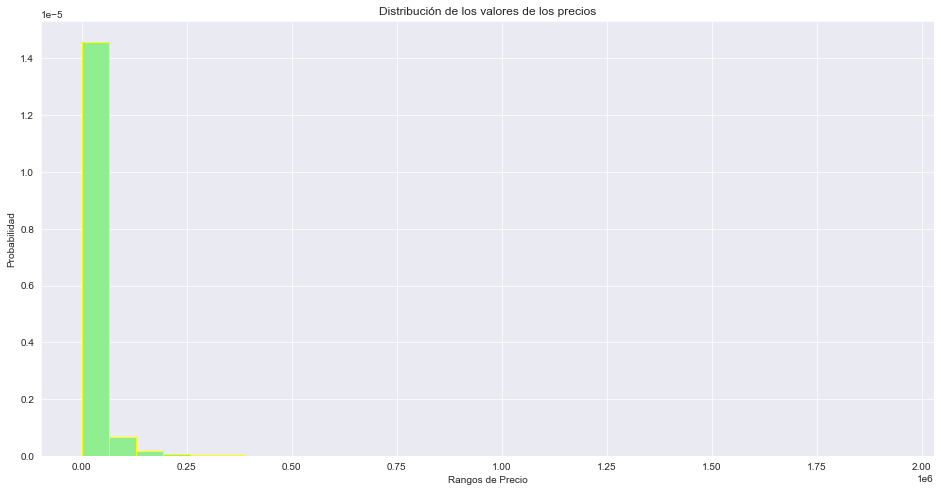

In [24]:
plt.figure(figsize=(16,8))
plt.hist(df_train['price'], bins=30, fc="lightgreen", ec="yellow", density=True) 
plt.gca().set(title='Distribución de los valores de los precios',
              ylabel='Probabilidad', 
              xlabel='Rangos de Precio')
plt.show()

Text(0.5, 1.0, 'Distribución de los precios')

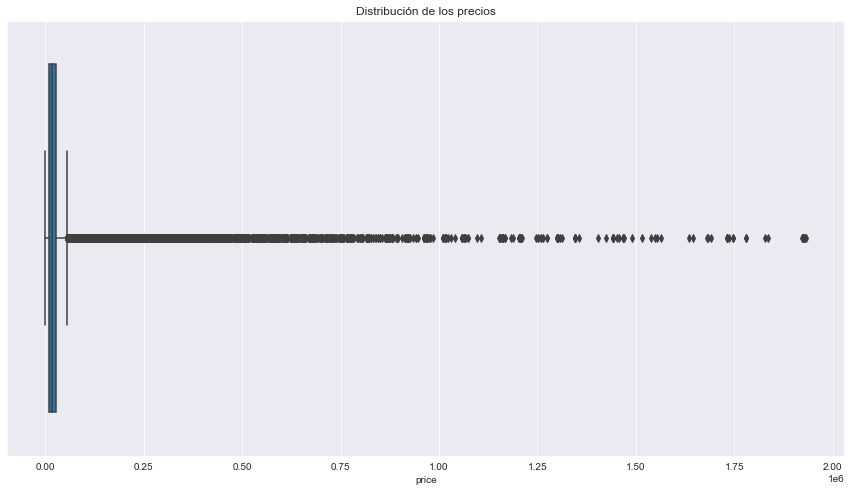

In [25]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df_train["price"])
plt.title('Distribución de los precios')

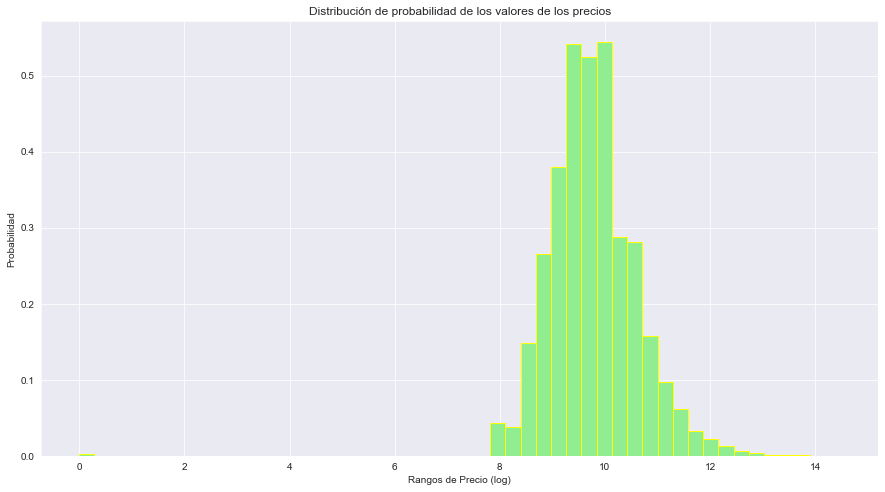

In [26]:
plt.figure(figsize=(15,8))
n, bins, rectangles = plt.hist(np.log1p(df_train['price']), bins=50, fc="lightgreen", ec="yellow", density=True) 
plt.gca().set(title='Distribución de probabilidad de los valores de los precios',
              ylabel='Probabilidad', 
              xlabel='Rangos de Precio (log)')
plt.show()

Text(0.5, 1.0, 'Distribución de los precios (log)')

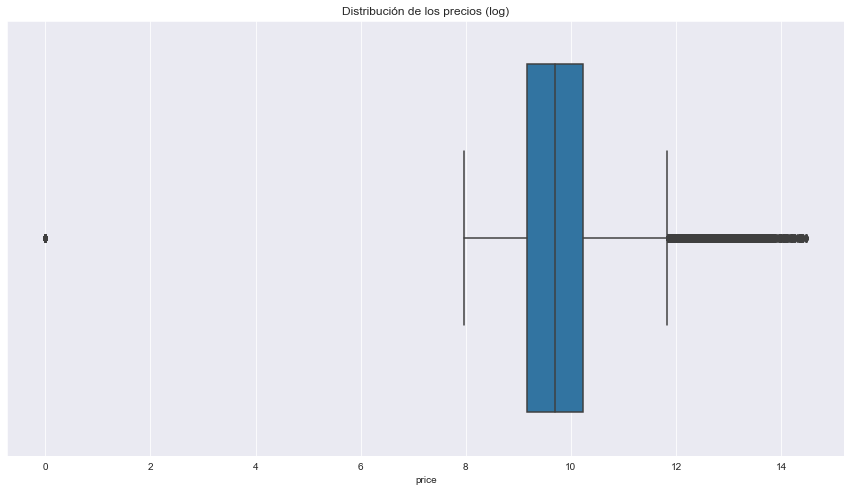

In [27]:
plt.figure(figsize=(15,8))
sns.boxplot(x=np.log1p(df_train['price']))
plt.title('Distribución de los precios (log)')

In [28]:
gr_price_brands = df_train.groupby(['brand_name']).mean()[['price']].sort_values(by='price', ascending=False)
gr_price_brands = gr_price_brands.reset_index()

# vemos las que sean más caras que el percentil 90 de estas, estas se consideran como marcas caras
gr_price_brands = gr_price_brands[gr_price_brands['price'] > np.percentile(gr_price_brands['price'], 90)]
gr_price_brands

,brand_name,price
0,Demdaco,412698.000000
1,Oris,288600.000000
2,MCM Worldwide,277383.080000
3,EVGA,275132.000000
4,Saint Laurent,253880.545455
...,...,...
438,Zobo,49543.000000
439,Sun Mountain,49543.000000
440,Blackmilk,49382.666667
441,Wacom,49318.533333


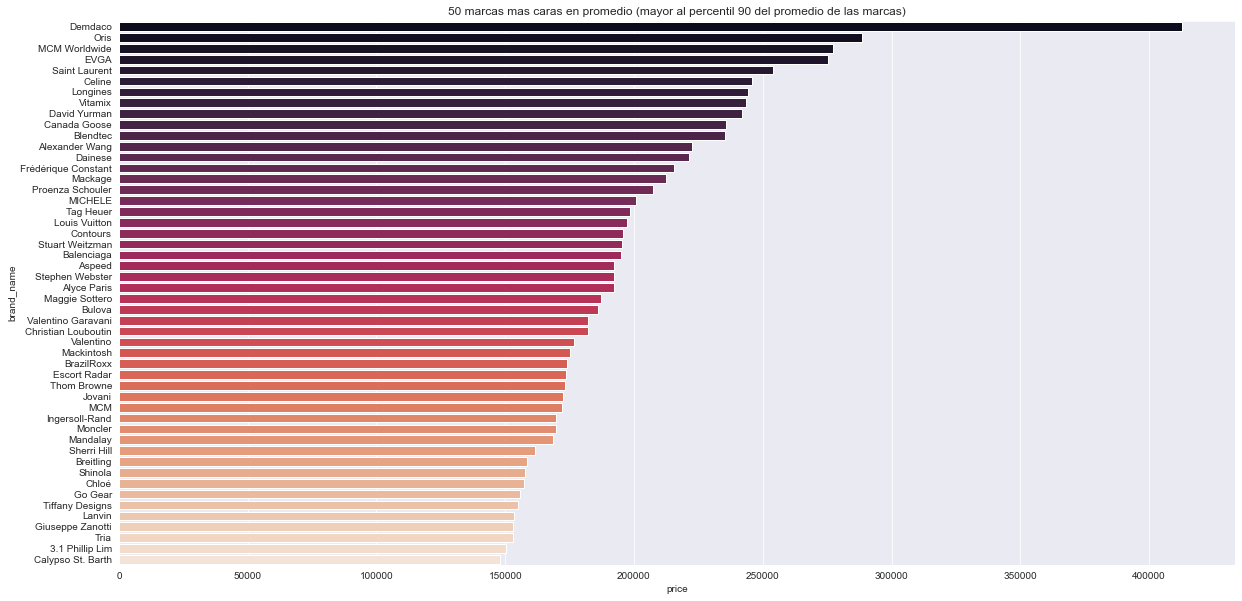

In [29]:
fig, ax = plt.subplots(figsize=(20,10),nrows=1)
sns.barplot(data=gr_price_brands.head(50), y='brand_name', x='price', palette="rocket",ax=ax, orient='h')
ax.set_title('50 marcas mas caras en promedio (mayor al percentil 90 del promedio de las marcas)')
plt.show()

In [30]:
df_train['name'].describe()

count     1107152
unique     932709
top        Bundle
freq         1661
Name: name, dtype: object

In [31]:
df_name_counts = df_train.groupby(['name']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_name_counts

,name,counts
177150,Bundle,1661
693807,Reserved,337
224321,Converse,332
256218,Dress,301
218967,Coach purse,301
...,...,...
320114,Garanimals,1
320115,Garanimals 2piece set,1
320116,Garanimals Clothes Bundle - 2T/3T,1
320117,Garanimals Girls Boots,1


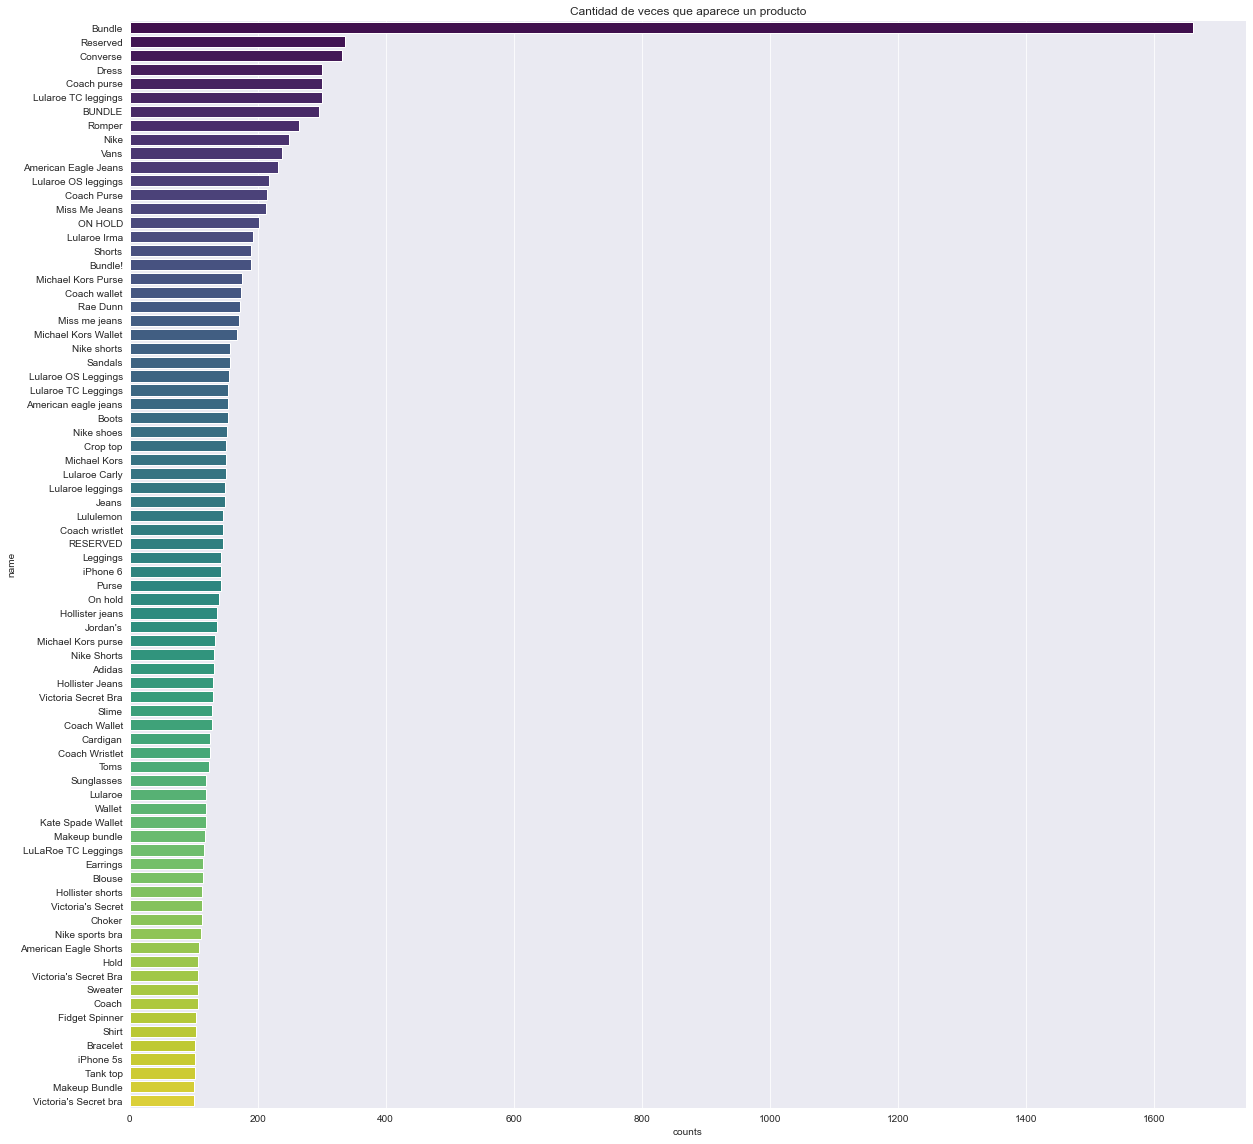

In [32]:
fig, ax = plt.subplots(figsize=(20,20),nrows=1)
sns.barplot(data=df_name_counts[df_name_counts['counts'] > 100], y='name', x='counts', palette="viridis", ax=ax, orient='h')
ax.set_title('Cantidad de veces que aparece un producto')
sns.despine(left=True, bottom=True)
plt.show()

## Preprocesamiento

In [33]:
# Colocaremos las categorías y las separaremos por categoría general, sub-categoría 1 y sub-categoría 2
def split_categories(df, categories):
    df_copy = df.copy()
    
    # hacemos split de la columna category_name en 3
    categories[['general_category','subcategory_1', 'subcategory_2']] = categories['category_name'].str.split('/',n=2,expand=True)
    
    # lo pasamos a df
    df_train_splited_categories = pd.merge(categories,
                 df_copy,
                left_on='category_id', right_on='category_name')

    
    # dropeamos las columnas que sobran
    df_train_splited_categories = df_train_splited_categories.drop(['category_id',
                                 'category_name_x',
                                 'category_name_y'], axis=1)
    # retornamos el nuevo dataset
    return df_train_splited_categories


In [34]:
# juntaremos las dos columnas de review_title y review_text
def join_text_columns(df):
    df_copy = df.copy()
    df_copy["name_and_description_brand"] = df_copy["name"] + " " + df_copy["item_description"]+  " " + df_copy["brand_name"] 
    df_copy.drop(['name','item_description', 'brand_name'], axis=1, inplace=True)

    return df_copy

In [35]:
# pasaremos las columnas categóricas a dummy
def get_dummies_categories(df):
    df_copy = df.copy()
    df_copy = pd.get_dummies(df_copy, columns=['general_category','subcategory_1', 
                                               'subcategory_2', 'item_condition_id'])    

    return df_copy

In [36]:
# esta función reduce la cantidad de categorías en las nuevas variables creadas

# https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b sacada de acá
from collections import Counter
def cumulatively_categorise(column,threshold=0.95,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    
    #Initialise a variable to calculate the sum of frequencies
    s=0
    
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
       
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list

    #Return only the transformed column if return_categories=False
    else:
        return new_column

def reduce_categories(df):
    df_copy = df.copy()
    transformed_column = cumulatively_categorise(df_copy['general_category'],
                                             return_categories_list=False,
                                            threshold=0.80)
    
    df_copy['general_category'] = transformed_column

    transformed_column = cumulatively_categorise(df_copy['subcategory_1'],
                                             return_categories_list=False,
                                            threshold=0.35)
    
    df_copy['subcategory_1'] = transformed_column

    transformed_column = cumulatively_categorise(df_copy['subcategory_2'],
                                             return_categories_list=False,
                                            threshold=0.25)
    df_copy['subcategory_2'] = transformed_column
    
    return df_copy

In [37]:
# preprocesamiento de columnas de texto
def pre_processing_text(df):
    df_copy = df.copy()
    
    # quitamos signos de puntuación 
    df_copy["name_and_description_brand"] = df_copy['name_and_description_brand'].str.replace('[^\w\s]',' ')
    
    # pasamos a lowercase
    df_copy['name_and_description_brand'] = df_copy['name_and_description_brand'].str.lower()
    
    # quitamos stopwords
    stop = set(stopwords.words('english'))
    df_copy['name_and_description_brand'] = df_copy['name_and_description_brand'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    
    return df_copy    


tokenizer = TfidfVectorizer().build_tokenizer() #Return a function that splits a string into a sequence of tokens considering unicode characters
lemmatizer = WordNetLemmatizer()

#stop-words: el vectorizador ya las remueve pero para mostrar las palabras más frecuente tiene sentido activarlo
remove_stops_here = False

def my_pre_processer(text, debug = False):
    results = []
    for token in tokenizer(text):
        clean_token = token.lower().strip('-').strip('_')
        token_pro = lemmatizer.lemmatize(clean_token) 
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

# vectorización tf-id, retorna los word vectors + los conjuntos de train y validacion
# X, y -> dataset
def vectorize_tfidvectorizer_data(X, y, kaggle=False):
    max_features = 100
    max_df = 0.75
    min_df = 20
    ngram_max = 1
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    
    vectorizer = TfidfVectorizer(stop_words='english',tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,
                                      binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))


    tfid_train = vectorizer.fit_transform(X_train['name_and_description_brand']) # fit + transform datos de train
    tfid_val = vectorizer.transform(X_val['name_and_description_brand']) # datos de validacion
    
    return tfid_train, tfid_val, X_train, y_train, X_val, y_val

# a las word vectors que acabamos de extraer, debemos unirlas con las otras características que ya trabajamos
def join_features(tfid_train, tfid_val, X_train, X_val):
    # pasamos las word vectors a matriz para poder trabajarlas
    tfid_train = tfid_train.todense()
    tfid_val = tfid_val.todense()
    
    # juntamos todo (las word vectors con todas las columnas que no sean name_and_description_brand)
    X_train = np.column_stack((tfid_train, X_train.drop('name_and_description_brand', axis=1).to_numpy()))
    X_val = np.column_stack((tfid_val, X_val.drop('name_and_description_brand', axis=1).to_numpy()))

    return X_train, X_val

In [38]:
# función para procesar todo el dataset y dejarlos listos para usarlos en los modelos
def process_dataset(df):
    # primero hacemos split de las categorías
    df = split_categories(df_train, categories)

    # juntamos las dos columnas de texto
    df = join_text_columns(df)
    
    # reducimos la cantidad de categorias
    df = reduce_categories(df)
    
    # obtenemos dummies de columnas categóricas
    df = get_dummies_categories(df)
    
    # procesamos la columna name_and_description_brand (stopwords, signos de puntuación, lowercase, etc)
    df = pre_processing_text(df)
    
    # quitamos columna target del dataset completo y la dejamos aparte
    y = df['price']
    X = df.drop('price', axis=1)

    # vectorizamos la data de texto (name_and_description_brand)
    tfid_train, tfid_val, X_train, y_train, X_val, y_val = vectorize_tfidvectorizer_data(X, y)
    
    # juntamos todo 
    X_train, X_val = join_features(tfid_train, tfid_val, X_train, X_val)
    
    # retornamos para aplicar los modelos
    return X_train, X_val, y_train, y_val 

In [39]:
X_train, X_val, y_train, y_val = process_dataset(df_train)

In [40]:
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)

X,y Train Shapes: (885721, 128) (885721,)
X,y Val Shapes: (221431, 128) (221431,)


In [41]:
X_train = csr_matrix(X_train)
X_val = csr_matrix(X_val)

## Modelamiento

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def linear_regression(X_train, y_train, X_val, y_val):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # predicciones para train
    y_train_pred = lr.predict(X_train)
    
    # scores train
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
    
    print(f' R^2 train score: {r2_train}')
    print(f' RMSE train score: {rmse_train}')
    print("")

    # predicciones para validacion
    y_val_pred = lr.predict(X_val)
    
    # scores validación
    r2_val = r2_score(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    print(f' R^2 validación score: {r2_val}')
    print(f' RMSE validación score: {rmse_val}')
    print("")

    return [(r2_train, rmse_train), (r2_val, rmse_val)]

In [43]:
linear_regression(X_train, y_train, X_val, y_val)

 R^2 train score: 0.129973362710757
 RMSE train score: 34668.910902787415

 R^2 validación score: 0.12499796286822762
 RMSE validación score: 35621.402781498706



[(0.129973362710757, 34668.910902787415),
 (0.12499796286822762, 35621.402781498706)]

In [44]:
from sklearn.linear_model import Lasso
def lasso_regression(X_train, y_train, X_val, y_val, alpha=1.0):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    # predicciones para train
    y_train_pred = lasso.predict(X_train)
    
    # scores train
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
    
    print(f' R^2 train score: {r2_train}')
    print(f' RMSE train score: {rmse_train}')
    print("")

    # predicciones para validacion
    y_val_pred = lasso.predict(X_val)
    
    # scores validación
    r2_val = r2_score(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    print(f' R^2 validación score: {r2_val}')
    print(f' RMSE validación score: {rmse_val}')
    print("")

    return [(r2_train, rmse_train), (r2_val, rmse_val)]

In [46]:
from sklearn.linear_model import Ridge
def ridge_regression(X_train, y_train, X_val, y_val, alpha=1.0):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # predicciones para train
    y_train_pred = ridge.predict(X_train)
    
    # scores train
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
    
    print(f' R^2 train score: {r2_train}')
    print(f' RMSE train score: {rmse_train}')
    print("")

    # predicciones para validacion
    y_val_pred = ridge.predict(X_val)
    
    # scores validación
    r2_val = r2_score(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    print(f' R^2 validación score: {r2_val}')
    print(f' RMSE validación score: {rmse_val}')
    print("")

    return [(r2_train, rmse_train), (r2_val, rmse_val)]

## Con test kaggle

In [48]:
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description
train_id,,,,,,
121326,Levana Jena baby monitor,Good,671,unknown,0,Used less than a year. Great condition. Smoke ...
1437618,Belle Dress BUNDLE,Good,633,Disney,0,"Beautiful Belle Dress! Size 2/4, but is defini..."
899441,Michael Kors Wallet,Good,1276,Michael Kors,0,"in great shape, hardly any ware!"
452401,Girls 5T Skirt set Free Shipping,Like New,638,unknown,1,Barely worn No holes or stains This is a 2pc s...
1225939,Cross silver stamped 925 necklace,New,1181,unknown,1,24 inches
...,...,...,...,...,...,...
1079099,Deadpool back in black set,New,988,unknown,1,"Deadpool back in black 1 1st print, variant, a..."
1135252,Black Shorts With Brown Belt,Good,1139,unknown,1,Shorts from forever21. Size 28
477391,Banana Republic pullover sweater,Like New,1236,Banana Republic,0,Cream


In [54]:
# función para procesar todo el dataset y dejarlos listos para usarlos en los modelos
def process_dataset_kaggle_submission(df_train, df_test):
    # primero hacemos split de las categorías
    df_train = split_categories(df_train, categories)
    df_test = split_categories(df_test, categories)

    # juntamos las dos columnas de texto
    df_train = join_text_columns(df_train)
    df_test = join_text_columns(df_test)

    # reducimos la cantidad de categorias
    df_train = reduce_categories(df_train)
    df_test = reduce_categories(df_test)

    # obtenemos dummies de columnas categóricas
    df_train = get_dummies_categories(df_train)
    df_test = get_dummies_categories(df_test)

    # procesamos la columna name_and_description_brand (stopwords, signos de puntuación, lowercase, etc)
    df_train = pre_processing_text(df_train)
    df_test = pre_processing_text(df_test)

    # quitamos columna target del dataset completo y la dejamos aparte
    y_train = df_train['price']
    X_train = df_train.drop('price', axis=1)
    
    max_features = 100
    max_df = 0.75
    min_df = 20
    ngram_max = 1
    
    # vectorizamos la data de texto (name_and_description_brand)
    vectorizer = TfidfVectorizer(stop_words='english',tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,
                                      binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))

    tfid_train = vectorizer.fit_transform(X_train['name_and_description_brand']) # fit + transform datos de train
    tfid_test = vectorizer.transform(df_test['name_and_description_brand']) # datos de validacion
    
    # pasamos las word vectors a matriz para poder trabajarlas
    tfid_train = tfid_train.todense()
    tfid_test = tfid_test.todense()
    
    # juntamos todo (las word vectors con todas las columnas que no sean name_and_description_brand)
    X_train = np.column_stack((tfid_train, X_train.drop('name_and_description_brand', axis=1).to_numpy()))
    X_test = np.column_stack((tfid_test, df_test.drop('name_and_description_brand', axis=1).to_numpy()))
    
    # retornamos para aplicar los modelos
    return X_train, X_test, y_train

In [55]:
X_train, X_test, y_train = process_dataset_kaggle_submission(df_train, df_test)

In [56]:
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

In [57]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predicciones para validacion
y_val_pred = lr.predict(X_test)

RMSE Kaggle: 39413.31105

In [ ]:
df_final['train_id'] = X_test.reset_index()['train_id']

In [ ]:
df_final=pd.DataFrame()
df_final['train_id']=df_test.reset_index()['train_id']
df_final['price']=y_val_pred
# df_final
df_final.to_csv('pred_test.csv', index=None)

## Conclusiones

* Sin realizar una hiperparametrización y un preprocesamiento no tan complejo, se puede obtener un baseline más o menos decente
* El trabajo con el modelado y el preprocesamiento puede mejorarse mucho más, por ejemplo en el preprocesamiento se pudo haber escogido otras formas de vectorizar el texto, tratar de otras maneras los datos nulos en la marca, crear nuevas columnas que puedan aportar más al modelo, etc. En el modelado, se pudo haber probado con otras técnicas para poder realizar una mejor selección de modelos, tales como cross-validation. Además, por temas de tiempo, no se pudo probar con los otros tipos de penalizaciones de regresión lineal con norma L1 y L2 (Lasso y Ridge), por lo que haber realizado un pipeline más extenso para la selección de modelos para escoger alphas óptimos que tomen estos regularizadores fue un trabajo que faltó realizar y que probablemente pudo haber mejorado los resultados obtenidos solo con regresión lineal clásica